In [1]:
import numpy as np
import pandas as pd
from IPython.display import display
from tqdm import tqdm
from collections import Counter
import os

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sb

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

from sklearn.decomposition import LatentDirichletAllocation
from bokeh.io import output_notebook
output_notebook()
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
from collections import defaultdict


Loading BokehJS ...

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload


In [2]:
filepath ='data/selected/'
filelist = os.listdir(filepath)
print(filelist)
len(filelist)

['heat recovery-selected.csv', 'green energy-selected.csv', 'wastewater treatment-selected.csv', 'maritime electrification-selected.csv', 'clean technology-selected.csv', 'waste reduction-selected.csv', 'green building-selected.csv', 'carbon emissions-selected.csv', 'renewable energy-selected.csv', 'smart home-selected.csv', 'additive manufacturing-selected.csv', 'energy efficient-selected.csv', 'geothermal-selected.csv', 'clean-energy-selected.csv', 'energy storage-selected.csv']


15

In [3]:
# Make NZ papers' number equals to other countries.
selected_df = pd.DataFrame()
for filename in filelist:
    raw_data = pd.read_csv(filepath + filename)
    nz_num = len(raw_data.query("`affiliation-country` == 'New Zealand'"))
    us_num = len(raw_data.query("`affiliation-country` == 'United States'"))
    uk_num = len(raw_data.query("`affiliation-country` == 'United Kingdom'"))
    ch_num = len(raw_data.query("`affiliation-country` == 'New Zealand'"))
    au_num = len(raw_data.query("`affiliation-country` == 'Australia'"))
    try:
        NZ_Data = raw_data.query("`affiliation-country` == 'New Zealand'")
        US_data = raw_data.query("`affiliation-country` == 'United States'").sample(n = nz_num,random_state=1)
        UK_data = raw_data.query("`affiliation-country` == 'United Kingdom'").sample(n = nz_num,random_state=1)
        CH_data = raw_data.query("`affiliation-country` == 'China'").sample(n = nz_num,random_state=1)
        AU_data = raw_data.query("`affiliation-country` == 'Austria'").sample(n = nz_num,random_state=1)
    except: pass
    raw_data_selected = pd.concat([NZ_Data,CH_data,US_data,UK_data,AU_data])
    selected_df = pd.concat([selected_df,raw_data_selected])

selected_df = selected_df.reset_index(drop=True)



In [4]:
# Select 5 countries paper
selected_df = pd.DataFrame()
for filename in filelist:
    raw_data = pd.read_csv(filepath + filename)
    selected_df = pd.concat([selected_df,raw_data])
countrylist = ['United States','China','United Kingdom','India','Australia','New Zealand']
selected_df = selected_df.query('`affiliation-country` == @countrylist')
selected_df = selected_df.reset_index(drop=True)

In [5]:
# selected_df.info()
country_num = selected_df.groupby('affiliation-country')['title'].nunique().to_dict()
country_num

{'Australia': 750,
 'China': 2325,
 'India': 906,
 'New Zealand': 97,
 'United Kingdom': 1366,
 'United States': 3905}

In [6]:
selected_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12801 entries, 0 to 12800
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   title                12801 non-null  object
 1   autor                12801 non-null  object
 2   doi                  12801 non-null  object
 3   citedby_count        12801 non-null  int64 
 4   affilname            12801 non-null  object
 5   affiliation-city     12801 non-null  object
 6   affiliation-country  12801 non-null  object
 7   abstract             12801 non-null  object
 8   topic                12801 non-null  object
dtypes: int64(1), object(8)
memory usage: 900.2+ KB


In [7]:
n_topics = 0
# Define helper functions
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

# Define helper functions
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)
# Define helper functions
def get_top_n_words_topic_model(n, keys, document_term_matrix, count_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        # print('hello {}'.format(temp_vector_sum))
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

In [8]:
reindexed_data = selected_df['abstract']
reindexed_data.index = selected_df.index
reindexed_data.head()

0                                              Unknown
1    Heavy metal pollution has become one of the mo...
2    Superparamagnetic iron oxide nanoparticles (SP...
3    Greenhouse gas emissions have significantly al...
4    Biodiesel has become more attractive recently ...
Name: abstract, dtype: object

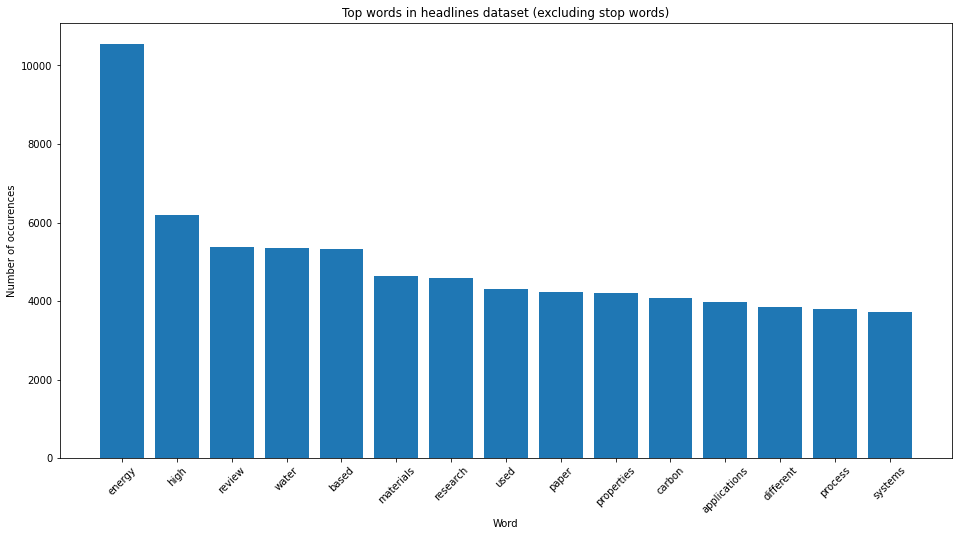

In [9]:
count_vectorizer = CountVectorizer(stop_words='english')
words, word_values = get_top_n_words(n_top_words=15,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=reindexed_data)
fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation=45);
ax.set_title('Top words in headlines dataset (excluding stop words)');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

In [10]:
n_topics = 12
small_count_vectorizer = CountVectorizer(stop_words='english', max_features=50000)
small_text_sample = reindexed_data.values
small_document_term_matrix = small_count_vectorizer.fit_transform(small_text_sample)

In [11]:
# LDA
lda_model = LatentDirichletAllocation(n_components=n_topics, learning_method='online', 
                                          random_state=0, verbose=0)
lda_topic_matrix = lda_model.fit_transform(small_document_term_matrix)

In [12]:
lda_keys = get_keys(lda_topic_matrix)
lda_categories, lda_counts = keys_to_counts(lda_keys)

In [13]:
top_n_words_lda = get_top_n_words_topic_model(10, lda_keys, small_document_term_matrix, small_count_vectorizer)

for i in range(len(top_n_words_lda)):
    print("Topic {}: ".format(i+1), top_n_words_lda[i])

Topic 1:  cells cell stress protein proteins effects mechanisms role including review
Topic 2:  concentrations samples antibiotics water wastewater 10 treatment high study respectively
Topic 3:  mantle high crust rocks arc subduction melting magma low continental
Topic 4:  ccu analysis gwp usa higher times ccs compared university sampling
Topic 5:  water metal removal soil metals treatment adsorption heavy organic wastewater
Topic 6:  energy research review paper materials based applications development power systems
Topic 7:  adsorption process biomass ph temperature production high removal carbon rate
Topic 8:  disease risk health patients evidence studies years cancer mortality effects
Topic 9:  properties review applications membrane drug tissue materials delivery used based
Topic 10:  properties surface high materials based carbon mechanical applications structure graphene
Topic 11:  data model water soil models high results based effects surface
Topic 12:  fuel diesel emissions b

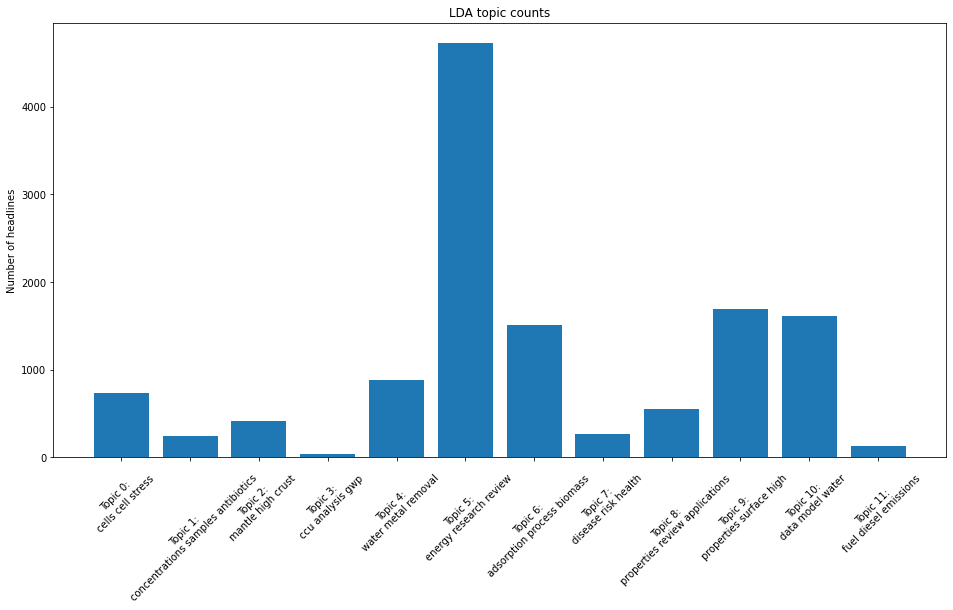

In [14]:
top_3_words = get_top_n_words_topic_model(3, lda_keys, small_document_term_matrix, small_count_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lda_categories]

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(lda_categories, lda_counts);
ax.set_xticks(lda_categories);
ax.set_xticklabels(labels,rotation = 45);
ax.set_title('LDA topic counts');
ax.set_ylabel('Number of headlines');

In [15]:
tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df = 0.5, 
                                min_df = 10)
docs_raw = selected_df.abstract
dtm_tf = tf_vectorizer.fit_transform(docs_raw)
tfidf_vectorizer = TfidfVectorizer(**tf_vectorizer.get_params())
dtm_tfidf = tfidf_vectorizer.fit_transform(docs_raw)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:2019: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. <class 'numpy.int64'> 'dtype' will be converted to np.float64.
  warnings.warn(


In [16]:
# for TF DTM
lda_tf = LatentDirichletAllocation(n_components=12, random_state=0)
lda_tf.fit(dtm_tf)
# for TFIDF DTM
lda_tfidf = LatentDirichletAllocation(n_components=12, random_state=0)
lda_tfidf.fit(dtm_tfidf)

LatentDirichletAllocation(n_components=12, random_state=0)

In [17]:
panel = pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer)
pyLDAvis.display(panel)
pyLDAvis.save_html(panel,"mutil_lda_result.html")

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pa

In [18]:
print(top_n_words_lda)

['cells cell stress protein proteins effects mechanisms role including review', 'concentrations samples antibiotics water wastewater 10 treatment high study respectively', 'mantle high crust rocks arc subduction melting magma low continental', 'ccu analysis gwp usa higher times ccs compared university sampling', 'water metal removal soil metals treatment adsorption heavy organic wastewater', 'energy research review paper materials based applications development power systems', 'adsorption process biomass ph temperature production high removal carbon rate', 'disease risk health patients evidence studies years cancer mortality effects', 'properties review applications membrane drug tissue materials delivery used based', 'properties surface high materials based carbon mechanical applications structure graphene', 'data model water soil models high results based effects surface', 'fuel diesel emissions biodiesel engine combustion engines ignition fuels gas']


In [19]:
# Get Country Rank under each topic.
topic_words=[]
for topic in top_n_words_lda:
    topic_word = topic.split(" ")
    topic_words.append(topic_word)
print(len(topic_words))

len(selected_df)
# print(selected_df.at[10,'abstract'])


threshold = 4
for topic in topic_words:
    country_dict  = defaultdict(int)
    for index in range(len(selected_df)):
        flag = 0
        words = selected_df.at[index,'abstract']
        country = selected_df.at[index,'affiliation-country']
        for top_word in topic:
            if top_word in words:
                flag +=1
            if flag>threshold:
                country_dict[country]+=1
                break
    # normalise the result on the ranking step.
    country_precent = defaultdict(float)
    for key,value in country_dict.items():
        country_precent[key] = round(value/country_num[key],4)
        pass
    country_precent = dict(sorted(country_precent.items(), key= lambda item: item[1],reverse=True))
    print("topic {} is-----".format(topic_words.index(topic)))
    
    print(country_precent.items())
    



12
topic 0 is-----
dict_items([('United States', 0.0461), ('United Kingdom', 0.0417), ('India', 0.0408), ('Australia', 0.0227), ('China', 0.0215), ('New Zealand', 0.0103)])
topic 1 is-----
dict_items([('India', 0.0695), ('China', 0.0563), ('Australia', 0.0507), ('United States', 0.0356), ('United Kingdom', 0.0242), ('New Zealand', 0.0103)])
topic 2 is-----
dict_items([('New Zealand', 0.0722), ('Australia', 0.0653), ('China', 0.0426), ('United States', 0.0348), ('United Kingdom', 0.0307), ('India', 0.0055)])
topic 3 is-----
dict_items([('United States', 0.0003)])
topic 4 is-----
dict_items([('India', 0.1777), ('China', 0.0697), ('Australia', 0.0667), ('New Zealand', 0.0619), ('United Kingdom', 0.0271), ('United States', 0.0269)])
topic 5 is-----
dict_items([('India', 0.3079), ('China', 0.2576), ('Australia', 0.2533), ('New Zealand', 0.2268), ('United Kingdom', 0.202), ('United States', 0.1403)])
topic 6 is-----
dict_items([('India', 0.2781), ('New Zealand', 0.2577), ('Australia', 0.1747

### Focus on NZ data

In [20]:
filepath = 'data/NZ/Nz_abstract/'
filelist = os.listdir(filepath)
print(filelist)

['maritime electrification_NZ-selected.csv', 'smart home_NZ-selected.csv', 'zero waste_NZ-selected.csv', 'green building_NZ-selected.csv', 'additive manufacturing_NZ-selected.csv', 'green energy_NZ-selected.csv', 'clean-energy_NZ-selected.csv', 'renewable energy_NZ-selected.csv', 'carbon emissions_NZ-selected.csv', 'heat recovery_NZ-selected.csv', 'wastewater treatment_NZ-selected.csv', 'energy storage_NZ-selected.csv', 'geothermal_NZ-selected.csv', 'waste reduction_NZ-selected.csv', 'energy efficient_NZ-selected.csv', 'clean technology_NZ-selected.csv']


In [21]:
NZ_data = pd.DataFrame()
for filename in filelist:
    raw_data = pd.read_csv(filepath + filename)
    NZ_data = pd.concat([NZ_data,raw_data])
    pass
NZ_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1557 entries, 0 to 129
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   title                1557 non-null   object
 1   autor                1557 non-null   object
 2   doi                  1557 non-null   object
 3   citedby_count        1557 non-null   int64 
 4   affilname            1557 non-null   object
 5   affiliation-city     1557 non-null   object
 6   affiliation-country  1557 non-null   object
 7   abstract             1557 non-null   object
 8   topic                1557 non-null   object
dtypes: int64(1), object(8)
memory usage: 121.6+ KB


In [22]:
topic_num = 6
tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df = 0.5, 
                                min_df = 10)
docs_raw = NZ_data.abstract
dtm_tf = tf_vectorizer.fit_transform(docs_raw)
tfidf_vectorizer = TfidfVectorizer(**tf_vectorizer.get_params())
dtm_tfidf = tfidf_vectorizer.fit_transform(docs_raw)
# for TF DTM
lda_tf = LatentDirichletAllocation(n_components=topic_num, random_state=0)
lda_tf.fit(dtm_tf)
# for TFIDF DTM
lda_tfidf = LatentDirichletAllocation(n_components=topic_num, random_state=0)
lda_tfidf.fit(dtm_tfidf)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:2019: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. <class 'numpy.int64'> 'dtype' will be converted to np.float64.
  warnings.warn(


LatentDirichletAllocation(n_components=6, random_state=0)

In [23]:
panel = pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer)
pyLDAvis.display(panel)
pyLDAvis.save_html(panel,"NZ_data_lda_result.html")

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
